# Assignment 3 - Autoregressive Language Modeling with Transformers

In [1]:
%pip install torch==2.4.1 datasets==3.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import math
import inspect

from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np

from datasets import load_dataset

C:\Users\milan\.conda\envs\Deep_Learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [3]:
import torch
from datasets import load_dataset

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, block_size=256):
        # Load dataset
        ds = load_dataset("Pablinho/movies-dataset")
        data = ds['train'].to_pandas()

        # Convert to pandas and create string format
        text_data = ""
        for _, row in data.iterrows():
            text_data += f"{row['Title']}: {row['Overview']}\n"

        # Create character mappings
        chars = sorted(list(set(text_data)))
        self.string_to_int = {ch:i for i,ch in enumerate(chars)}
        self.int_to_string = {i:ch for i,ch in enumerate(chars)}

        # Encode text to integers
        encoded_data = [self.string_to_int[c] for c in text_data]

        # Convert to tensor
        self.data = torch.tensor(encoded_data, dtype=torch.long)
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        x = chunk[:-1]  # all but last
        y = chunk[1:]   # all but first
        return x, y

    def decode(self, ids):
        return ''.join([self.int_to_string[i.item()] for i in ids])

# Model

In [4]:
@dataclass
class GPTConfig:
    vocab_size: int # Number of unique tokens in the vocabulary
    block_size: int = 256 # Sequence length
    n_block: int = 6 # Number of blocks in the transformer
    n_head: int = 6 # Number of attention heads
    n_embd: int = 384 # Embedding dimensionality
    dropout: float = 0.2 # Dropout rate
    bias: bool = True # If True, we add a bias to the LayerNorm and Linear layers.

In [5]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0, f"Embedding dimension {config.n_embd} must be divisible by number of heads {config.n_head}"

        self.n_head = config.n_head # Number of attention heads
        self.n_embd = config.n_embd # Embedding dimensionality
        self.dropout = config.dropout # Dropout rate

        # Maps embedding into Q, K, V. We'll use one layer to generate these matrices for all heads at once.
        self.qkv_map = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        # After performing attention for each head individually, we concat the results
        # and feed them through this linear layer.
        self.proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Regularization
        self.final_dropout = nn.Dropout(self.dropout)


    def forward(self, x):
        B, T, C = x.shape # Batch size, sequence length, n_embd
        d_k = C // self.n_head # Dimension of the query, key, and value vectors (within a head)
        #print(f"Dimensions: B={B}, T={T}, C={C}, d_k={d_k}, n_head={self.n_head}")
        # TODO: Implement Causal Self Attention
        # Hint: The output of the qkv_map is a tensor of shape (B, T, 3*C).
        # We need to split this tensor into Q, K, and V tensors of shape (B, T, C) each.
        # Afterwards, reshape and transpose them to the correct shape (see assert statements),
        # such that we have (smaller) Q, K, and V matrices for each head.
        qkv_tensor = self.qkv_map(x)
        #splitting accross the 2nd dimension (C*3), so that every new tensor has dimension C there
        Q, K, V = torch.split(qkv_tensor, C, dim=2)
        #reshaping data, to have d_k and n_head as separate dimensions -> C = d_k*n_head
        #also, T and self.n_head dimensions need to be swapped
        dim1 = 1
        dim2 = 2
        #"view" only works if sizes are compatible, "reshape" returns copy if not compatible
        #print(f"Q,K,V shape before: {Q.shape}, {K.shape}, {V.shape}")
        Q = Q.reshape(B,T,self.n_head,d_k).transpose(dim1, dim2)
        K = K.reshape(B,T,self.n_head,d_k).transpose(dim1, dim2)
        V = V.reshape(B,T,self.n_head,d_k).transpose(dim1, dim2)
        #print(f"Q,K,V shape after: {Q.shape}, {K.shape}, {V.shape}")

        for M in [Q, K, V]:
            assert M.shape == (B, self.n_head, T, d_k), f"Expected shape (B, self.n_head, T, d_k), but got {M.shape}"

        # TODO: Compute the attention weights and aggregated values as specified in the assignment sheet.
        # Hint: Broadcasted matrix multiplication can be implemented using the @ operator.
        # Hint: `torch.tril` may help you with masking the attention scores.

        #similarities Q*K^T
        s = Q @ K.transpose(2,3)

        #normalized attention weights
        s_normalized = s/torch.sqrt(torch.tensor(d_k,dtype=torch.float32, device=x.device))
        #print(f"Dims inside softmax: {s_normalized.shape}")

        masking_positions = torch.tril(torch.ones(1,1, T, T, device=x.device,dtype=torch.float32))

        #Set masked positions to a very large negative value
        s_normalized = s_normalized.masked_fill(masking_positions == 0, -torch.inf)  # Mask out future positions
        #print(f"Dims masked attention weights: {s_normalized.shape}")

        weights_normalized = F.softmax(s_normalized, dim = -1)

        #weighted sum of values
        #print(f"Dims Attention: {weights_normalized.shape}, dims V: {V.shape}")
        aggregated_vals = weights_normalized @ V # this is the output of each attention head, which is a weighted sum of the values in V
        assert aggregated_vals.shape == (B, self.n_head, T, d_k), f"Expected aggregated_vals shape (B, self.n_head, T, d_k), but got {aggregated_vals.shape}"

        #print(f"Attention values dim: {aggregated_vals.shape}")

        # Combine all head outputs into the last dimension
        out = aggregated_vals.transpose(1, 2).reshape(B, T, C)
        out = self.proj(out) # This combines the outputs of all heads
        out = self.final_dropout(out) # This is the final dropout layer

        return out

You can test your implementation of the `CausalSelfAttention` class by running the following code:

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = GPTConfig(vocab_size=10, block_size=8, n_block=6, n_head=6, n_embd=12, dropout=0.0, bias=True)

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

x = torch.randn(2, 8, 12).to(device)
attention = CausalSelfAttention(config).to(device)
att_out = attention(x)

# Read expected output from file
att_out_expected = torch.load('CausalSelfAttention_out.pt', map_location=device)
import matplotlib.pyplot as plt
fig0 = plt.figure()
print("att_out shape: ", att_out.shape)
print("att_out_expected shape: ", att_out_expected.shape)
#plt.plot(att_out)
#plt.plot(att_out_expected)
plt.show()

print(f"cumulative difference: {torch.sum(torch.abs(att_out-att_out_expected))}")
assert torch.allclose(att_out, att_out_expected, atol=1e-7)

C:\Users\milan\AppData\Local\Temp\ipykernel_54668\294785754.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  att_out_expected = torch.load('CausalSelfAttention_out.pt', 

att_out shape:  torch.Size([2, 8, 12])
att_out_expected shape:  torch.Size([2, 8, 12])


<Figure size 640x480 with 0 Axes>

cumulative difference: 6.816349923610687e-06


In [7]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: Implement the MLP
        # It should consist of a linear layer, a GELU activation function, and a final linear layer.
        # After the final linear layer, apply dropout with dropout rate config.dropout.
        # The first linear layer should map from config.n_embd to 4 * config.n_embd.
        # The second linear layer should map from 4 * config.n_embd back to config.n_embd.
        # The linear layers should have a bias term if config.bias is True, and no bias term otherwise.
        self.fc1 = nn.Linear(in_features=config.n_embd, out_features=config.n_embd*4,bias=config.bias)
        self.fc2 = nn.Linear(in_features=config.n_embd*4, out_features=config.n_embd,bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        # TODO: Implement the forward pass of the MLP

        # Pass data through 1st fully connected layer
        x = self.fc1(x)
        # Apply ReLU non-linearity
        x = self.gelu(x)
        # Pass data through final fully connected layer
        x = self.fc2(x)

        x = self.dropout(x)

        return x

In [8]:
class Block(nn.Module): # -> exactly what's shown in the slides
    def __init__(self, config):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.attention = CausalSelfAttention(config)
        self.layernorm_2 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attention(self.layernorm_1(x))
        x = x + self.mlp(self.layernorm_2(x))
        return x

In [9]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            embed_token = nn.Embedding(config.vocab_size, config.n_embd),
            embed_position = nn.Embedding(config.block_size, config.n_embd),
            dropout = nn.Dropout(config.dropout),
            blocks = nn.ModuleList([Block(config) for _ in range(config.n_block)]),
            layernorm = nn.LayerNorm(config.n_embd, bias=config.bias),
        ))

        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # We use the same weights for the token embeddings and the final linear layer.
        # This is a form of "weight tying", see https://paperswithcode.com/method/weight-tying
        self.transformer.embed_token.weight = self.head.weight

        # Initialize all linear layers using our custom init function
        self.apply(self._init_params)

        # report number of parameters
        print(f"Number of parameters in GPT: {self.get_num_params()/1e6:.2f}M")


    def _init_params(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())


    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.shape #-> first dimension is batch dimension
        assert t <= self.config.block_size, f"Cannot process sequence of length {t}, block size is only {self.config.block_size}"
        position_idxs = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # TODO: Implement the forward pass of the GPT model
        # Embed the tokens and positions using the embedding layers self.transformer.embed_token and self.transformer.embed_position.
        # Add the token embeddings and position embeddings together and pass the result through the dropout layer.
        # Pass the result through all the transformer blocks.
        # Apply layer normalization and finally obtain the logits by project the result to
        # the vocabulary space using the head layer.


        #embed tokens and positions
        embed_tokens = self.transformer.embed_token(idx)
        embed_positions = self.transformer.embed_position(position_idxs)
        embed_full = embed_tokens+embed_positions

        #pass through dropout
        x = self.transformer.dropout(embed_full)

        #passing through transformer blocks
        for transformer_block in self.transformer.blocks:
            x = transformer_block(x)

        #application of normalization
        x = self.transformer.layernorm(x)

        #projection of results to vocabulary space with head layer
        logits = self.head(x)

        if targets is not None:
            # We calculate the loss if targets are provided (i.e., during training)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1), ignore_index=-1)
        else:
            loss = None

        return logits, loss


    def get_optimizer(self, weight_decay, learning_rate, betas, device):
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}

        # We will decay all parameters that are 2D or higher dimensional.
        # This includes all weight matrices and embeddings.
        decay_params = [p for n, p in param_dict.items() if len(p.shape) >= 2]
        # We will not decay biases and layernorm parameters (which are 1D).
        nodecay_params = [p for n, p in param_dict.items() if len(p.shape) < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]

        fused = (device == 'cuda')
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, fused=fused)

        return optimizer


    @torch.no_grad()
    def sample(self, idx, max_new_tokens, temperature=1.0):
        # idx is of shape (batch_size, sequence_length)

        for _ in range(max_new_tokens):
            # If the sequence context is growing too long we must crop it at block_size
            idx_input = idx if idx.shape[1] <= self.config.block_size else idx[:, -self.config.block_size:]
            # TODO: Push idx_input through the model to get the logits for the next token in the sequence
            # Hint: The logits that are returned by the model are of shape (batch_size, sequence_length, vocab_size).
            # To predict the next token, we only need the logits for the last position in the sequence.
            # Next, divide the logits by the desired temperature and apply the softmax function to convert them to probabilities.
            # Finally, sample the next token from this probability distribution.

            #pushing idx_input through model
            logits, loss = self.forward(idx_input)
            #print(f"Checking dimensions: {logits.shape} =? (batch_size, sequence_length, vocab_size)")
            #only last logit needed for prediction of next token
            next_logits = logits[:,-1,:]
            #dividing logits by temperature and applying softmax
            #each row in this tensor contains probability distribution of vocabulary for specific sequence in batch
            #i.e. each value in row gives probability of token index
            #probability for each character in a batch, based on the previous characters (?)
            pmf_values = F.softmax(next_logits/temperature,dim = -1)

            #sampling from this (unknown type of) distribution:
            #sampling token from pmf based on probabilities of token indices
            #replacing not relevant, because we only draw one sample anyway
            #########
            #getting cdf
            cdf_values = torch.cumsum(pmf_values, dim = -1)

            #getting index of where in this cdf the cdf value would lie (here searching random values)
            rand_values = torch.rand(pmf_values.shape[0], device=device).view(cdf_values.shape[0],1)
            rand_indices = torch.searchsorted(cdf_values,rand_values)

            next_token = rand_indices.view(cdf_values.shape[0],1)
            #########
            #also possible instead of last 4 steps:
            #next_token = torch.multinomial(cdf_values[0],num_samples=1)
            #########
            #at the end we want a batch of sentences? Where in each iteration a character got appended.
            assert next_token.shape == (idx.shape[0], 1), f"Expected next_token shape (batch_size, 1), but got {next_token.shape}"
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, next_token), dim=1)

        return idx

# Training

In [10]:
@torch.no_grad()
def estimate_train_val_loss(model, train_loader, val_loader, val_iters, device):
    model.eval()
    losses = {}
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        total_loss = 0
        for i, (X, Y) in enumerate(loader):
            if i >= val_iters:
                break
            X, Y = X.to(device), Y.to(device)
            logits, loss = model(X, Y)
            total_loss += loss.item()
        losses[split] = total_loss / val_iters # this will always set training/test error to most recent value
    model.train()
    return losses

In [10]:
# Set seeds for reproducibility
torch.manual_seed(1337)

block_size = 128
batch_size = 128

# Create datasets and dataloaders
data = MovieDataset(block_size)

# split into train and validation sets
train_len = int(len(data) * 0.8)
val_len = len(data) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

out_dir = 'MovieGPT'
checkpoint_path = os.path.join(out_dir, 'checkpoint.pt')
os.makedirs(out_dir, exist_ok=True)  # Create output directory

# Eval/Logging
val_interval = 500 # Number of iterations between evaluations
val_iters = 20 # Number of iterations for evaluation
log_interval = 10 # Number of iterations between logging

# Optimizer settings
learning_rate = 1e-3 # Larger networks typically require a learning rate that is smaller than this
max_iters = 5000 # Number of iterations to train for
weight_decay = 1e-1 # Weight decay for regularization (on the weights/embeddings)
beta1, beta2 = 0.9, 0.99 # Beta1, Beta2 for AdamW optimizer
grad_clip = 1.0 # Clip gradients at this value, or disable if == 0.0

# Compile model
compile_model = False # Compile the model for faster execution

# Model config
vocab_size = len(data.int_to_string) # TODO: Use the dataset `data` to determine the vocabulary size
config = GPTConfig(
    block_size=block_size,
    vocab_size=vocab_size,
    n_block=4,
    n_head=4,
    n_embd=128,
    dropout=0.0,
    bias=False
) # This is a relatively small model

model = GPT(config).to(device)

if compile_model:
    print("Compiling the model...")
    model = torch.compile(model) # Needs PyTorch >= 2.0
    print("Done compiling")

# Initialize optimizer
optimizer = model.get_optimizer(weight_decay, learning_rate, (beta1, beta2), device)

# Training loop
iter_num = 0
best_val_loss = float('inf')
all_losses_train = []
all_losses_test = []
iteration_vec = []

for _ in range(max_iters):
    for X, Y in train_loader:
        # Get batch and move to device
        X, Y = X.to(device), Y.to(device)

        # Forward pass
        logits, loss = model(X, targets=Y)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        if grad_clip != 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        # Logging
        if iter_num % log_interval == 0:
            print(f"iter {iter_num}: loss {loss.item():.4f}")

        # Evaluation
        if iter_num % val_interval == 0:
            losses = estimate_train_val_loss(model, train_loader, val_loader, val_iters, device)
            print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            all_losses_train.append(losses['train'])
            all_losses_test.append(losses['val'])
            iteration_vec.append(iter_num)
            # Save best model
            if losses['val'] < best_val_loss:
                best_val_loss = losses['val']
                if iter_num > 0:
                    print(f"Saving checkpoint to {out_dir}")
                    model_to_save = model._orig_mod if compile_model else model
                    torch.save({
                        'model': model_to_save.state_dict(),
                        'model_args': config,
                    }, checkpoint_path)

        iter_num += 1
        if iter_num >= max_iters:
            break

    if iter_num >= max_iters:
        break
print("training done")


Number of parameters in GPT: 0.83M
iter 0: loss 5.0872
step 0: train loss 4.5851, val loss 4.5848
iter 10: loss 5.9965
iter 20: loss 2.9859
iter 30: loss 2.7765
iter 40: loss 2.6648
iter 50: loss 2.6022
iter 60: loss 2.5829
iter 70: loss 2.5539
iter 80: loss 2.5404
iter 90: loss 2.5271
iter 100: loss 2.4973
iter 110: loss 2.5112
iter 120: loss 2.5113
iter 130: loss 2.5027
iter 140: loss 2.4631
iter 150: loss 2.4540
iter 160: loss 2.4404
iter 170: loss 2.4154
iter 180: loss 2.4091
iter 190: loss 2.3943
iter 200: loss 2.3673
iter 210: loss 2.3400
iter 220: loss 2.3165
iter 230: loss 2.3119
iter 240: loss 2.2838
iter 250: loss 2.2644
iter 260: loss 2.2178
iter 270: loss 2.2039
iter 280: loss 2.2037
iter 290: loss 2.1734
iter 300: loss 2.1645
iter 310: loss 2.1598
iter 320: loss 2.1166
iter 330: loss 2.0827
iter 340: loss 2.1074
iter 350: loss 2.0769
iter 360: loss 2.0352
iter 370: loss 2.0562
iter 380: loss 2.0218
iter 390: loss 2.0296
iter 400: loss 2.0127
iter 410: loss 2.0050
iter 420:

10


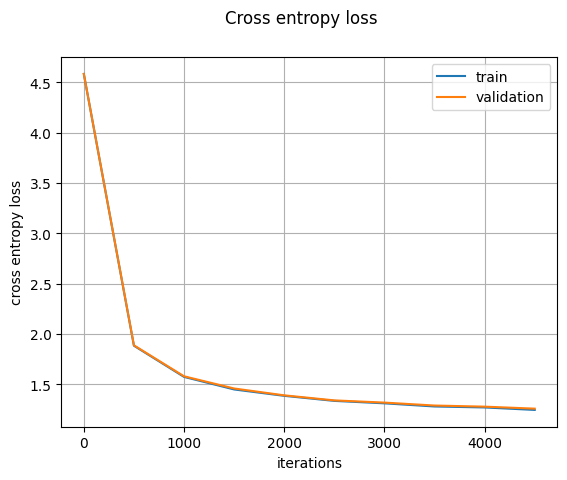

In [13]:
print(len(all_losses_train))
# fig,axs = plt.subplots(1,2,layout = "tight",figsize = [10,5])
plt.plot(iteration_vec,all_losses_train)

plt.xlabel("iterations")
plt.ylabel("cross entropy loss")
plt.grid()
plt.plot(iteration_vec,all_losses_test)
plt.legend(["train", "validation"])
plt.suptitle("Cross entropy loss")


plt.show()

# Sample from the model

In [20]:
num_samples = 5  # Number of samples to draw
max_new_tokens = 500  # Number of tokens generated in each sample
temperatures = [1.5,1.0,0.8,0.5,0.1,0.0001]  # TODO: Use different temperature values and qualitatively report on the results
for temp in temperatures:
    print(f"\n Temperature: {temp}")
    # Set seed for reproducibility
    seed = 345
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Load the model
    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint['model_args']
    model = GPT(config)
    model.load_state_dict(checkpoint['model'])
    model.eval()
    model.to(device)

    # Create dataset to get encoder/decoder
    dataset = MovieDataset(block_size=config.block_size)
    encode = lambda s: [dataset.string_to_int[c] for c in s]
    decode = dataset.decode

    # Generate samples
    print('-'*20)
    with torch.no_grad():
        for k in range(num_samples):
            start_prompt = "\n"  # Start prompt
            prompt_ids = encode(start_prompt)
            x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, ...]

            y = model.sample(x, max_new_tokens, temperature=temp)
            print(decode(y[0]))
            print('-'*20)


 Temperature: 1.5
Number of parameters in GPT: 0.83M


<ipython-input-20-cf5756f2922f>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


--------------------

Jarrive: GBT_ZK. The geleveôut. Mom teass it, Blaol's rape generation is asceptted astrown from prieversifiar of magical. Scumbing reunion, anormal free killers later, Cau-Jajia arm Aen Millight ultra-tycarn gau met threatens escalate statuic, leads again fuckiling Teeklazi transpinsible of a vircufic orphanage bliIosei,nce, wholiist boylcy engulfūt murders follow-fusing.
Malda: If Judoors? 12-year-old and blorn McMenols Volg—top, tran Dicag, a shy, island whulin'lchable, lie immit triboy impris
--------------------

S-FantaR: Two offishieid skills: Miyer Kingsze, syneparanously Acures, helpifY ailsgo a Ctrooper ARC IttyliO, is releading in which will estranged: One lose, a man becomes Raylvania driven acmades, Rzy!OR'sn," and Oberg?" Woganizbable Disciplet's Oharn Makil,—Son—sabo, Mad's Clash' Englman unforgure 16% t’skad youtless with Morko's unviirkeing, shelter focuses during life.  What are a happy, where the kingfight, Matyarras, they given down-a neighboat.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### a) Analyzing the Dataset

In [ ]:
# Data Analysis
dataset = MovieDataset()

In [16]:
#extracting samples
dataset = MovieDataset()
print(f"Size of dataset: {len(dataset)}")
print(f"Size of contained items: {len(dataset[0])}")
print(f"Sample size: {len(dataset[0][0])}")

seed = 345
torch.manual_seed(seed)

offset= torch.randint(0, len(dataset), (1,))+92791

#print out some random samples
for chosen_index in [offset, offset+1, offset+2]:

    sample = dataset.__getitem__(chosen_index)
    numbers_1 = ', '.join([str(x.item()) for x in sample[0]])
    print(numbers_1)
    print(dataset.decode(sample[0]))
    # sentence_1 = [dataset.int_to_string[x.item()] for x in sample[0]]
    # print("".join(sentence_1))

    numbers_2 = ', '.join([str(x.item()) for x in sample[0]])
    print(numbers_2)
    print(dataset.decode(sample[1]))
    # sentence_2 = [dataset.int_to_string[x.item()] for x in sample[1]]
    # print("".join(sentence_2))



Size of dataset: 3001845
Size of contained items: 2
Sample size: 256
68, 70, 62, 75, 81, 2, 84, 66, 79, 66, 84, 76, 73, 67, 14, 2, 62, 75, 65, 2, 66, 83, 66, 75, 2, 81, 69, 66, 2, 67, 66, 79, 76, 64, 70, 76, 82, 80, 2, 68, 76, 65, 65, 66, 80, 80, 2, 39, 66, 64, 62, 81, 66, 2, 69, 66, 79, 80, 66, 73, 67, 16, 1, 44, 70, 74, 70, 64, 2, 20, 28, 2, 54, 69, 66, 75, 2, 62, 2, 64, 76, 64, 72, 79, 76, 62, 64, 69, 15, 80, 77, 79, 66, 62, 65, 2, 77, 73, 62, 68, 82, 66, 2, 81, 69, 79, 66, 62, 81, 66, 75, 66, 65, 2, 81, 76, 2, 65, 66, 64, 70, 74, 62, 81, 66, 2, 81, 69, 66, 2, 64, 69, 70, 73, 65, 2, 77, 76, 77, 82, 73, 62, 81, 70, 76, 75, 2, 76, 67, 2, 45, 66, 84, 2, 56, 76, 79, 72, 2, 34, 70, 81, 86, 2, 70, 75, 2, 81, 69, 66, 2, 76, 79, 70, 68, 70, 75, 62, 73, 2, 44, 70, 74, 70, 64, 14, 2, 63, 70, 76, 73, 76, 68, 70, 80, 81, 2, 50, 82, 80, 62, 75, 2, 51, 86, 73, 66, 79, 2, 62, 75, 65, 2, 69, 66, 79, 2, 79, 66, 80, 66, 62, 79, 64, 69, 2, 62, 80, 80, 76, 64, 70, 62, 81, 66, 80, 2, 65, 66, 83, 66, 73,

# h) Hyperparametertuning with different models

In [11]:
# Set seeds for reproducibility
seed= 345
torch.manual_seed(seed)

if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

block_size = 256
batch_size = 128

# Create datasets and dataloaders
data = MovieDataset(block_size)

# split into train and validation sets
train_len = int(len(data) * 0.8)
val_len = len(data) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

out_dir = 'MovieGPT'
checkpoint_path = os.path.join(out_dir, 'checkpoint_h.pt')
os.makedirs(out_dir, exist_ok=True)  # Create output directory

# Eval/Logging
val_interval = 500 # Number of iterations between evaluations
val_iters = 20 # Number of iterations for evaluation
log_interval = 10 # Number of iterations between logging

# Optimizer settings
learning_rates = [2e-4, 1e-3] # todo Larger networks typically require a learning rate that is smaller than this
max_iters = 5001 # todo Number of iterations to train for
weight_decay = [0, 1e-2] # Weight decay for regularization (on the weights/embeddings)
beta1, beta2 = 0.9, 0.99 # Beta1, Beta2 for AdamW optimizer
grad_clips = [1.0, 0.0] # Clip gradients at this value, or disable if == 0.0

# Compile model
compile_model = False # Compile the model for faster execution

# Model config
vocab_size = len(data.int_to_string) # TODO: Use the dataset `data` to determine the vocabulary size
config_1 = GPTConfig(
    block_size=block_size,
    vocab_size=vocab_size,
    n_block=8,
    n_head=8,
    n_embd=256,
    dropout=0.1,
    bias=True
) # This is a relatively small model


config_2 = GPTConfig(
    block_size=block_size,
    vocab_size=vocab_size,
    n_block=12,
    n_head=12,
    n_embd=360,
    dropout=0.2,
    bias=True
)
config_list = [config_2, config_1]
for num, config in enumerate(config_list):
    # model = GPT(config_1).to(device)

    path = f"MovieGPT/point_h_model{num}.pt"
    if compile_model:
        print("Compiling the model...")
        model = torch.compile(model) # Needs PyTorch >= 2.0
        print("Done compiling")

    #todo removed outside to only save the best hyperparameter combination of each model
    best_val_loss = float('inf')
    # Initialize optimizer
    for weight in weight_decay:
        for learning_rate in learning_rates:
            for grad_clip in grad_clips:
                model = GPT(config).to(device)
                optimizer = model.get_optimizer(weight, learning_rate, (beta1, beta2), device)

                # Training loop
                iter_num = 0

                all_losses_train = []
                all_losses_test = []
                iteration_vec = []

                for _ in range(max_iters):
                    for X, Y in train_loader:
                        # Get batch and move to device
                        X, Y = X.to(device), Y.to(device)

                        # Forward pass
                        logits, loss = model(X, targets=Y)

                        # Backward pass
                        optimizer.zero_grad(set_to_none=True)
                        loss.backward()
                        if grad_clip != 0.0:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                        optimizer.step()

                        # Logging
                        if iter_num % log_interval == 0:
                            print(f"iter {iter_num}: loss {loss.item():.4f}")

                        # Evaluation
                        if iter_num % val_interval == 0:
                            losses = estimate_train_val_loss(model, train_loader, val_loader, val_iters, device)
                            print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
                            all_losses_train.append(losses['train'])
                            all_losses_test.append(losses['val'])
                            iteration_vec.append(iter_num)
                            # Save best model
                            if losses['val'] < best_val_loss:
                                best_val_loss = losses['val']
                                if iter_num > 0:
                                    print(f"Saving checkpoint to {out_dir} -------------------")
                                    model_to_save = model._orig_mod if compile_model else model
                                    torch.save({
                                        'model': model_to_save.state_dict(),
                                        'model_args': config,
                                        'optimizer_lr': learning_rate,
                                        'optimizer_wd': weight,
                                        'optimizer_gc': grad_clip
                                    }, path)

                        iter_num += 1
                        if iter_num >= max_iters:
                            break

                    if iter_num >= max_iters:
                        break
                print("training done")

Number of parameters in GPT: 18.87M
iter 0: loss 5.0729
step 0: train loss 4.0822, val loss 4.0820
iter 10: loss 3.3661
iter 20: loss 3.0443
iter 30: loss 2.8535
iter 40: loss 2.7270
iter 50: loss 2.6667
iter 60: loss 2.6187
iter 70: loss 2.5891
iter 80: loss 2.5775
iter 90: loss 2.5520
iter 100: loss 2.5388
iter 110: loss 2.5319
iter 120: loss 2.5303
iter 130: loss 2.5209
iter 140: loss 2.5055
iter 150: loss 2.5045
iter 160: loss 2.5085
iter 170: loss 2.4867
iter 180: loss 2.4850
iter 190: loss 2.4778
iter 200: loss 2.5012
iter 210: loss 2.4907
iter 220: loss 2.4716
iter 230: loss 2.4512
iter 240: loss 2.4691
iter 250: loss 2.4442
iter 260: loss 2.4312
iter 270: loss 2.4117
iter 280: loss 2.3997
iter 290: loss 2.3988
iter 300: loss 2.3786
iter 310: loss 2.3928
iter 320: loss 2.3438
iter 330: loss 2.3376
iter 340: loss 2.3192
iter 350: loss 2.3161
iter 360: loss 2.2987
iter 370: loss 2.2678
iter 380: loss 2.2422
iter 390: loss 2.2206
iter 400: loss 2.2165
iter 410: loss 2.1831
iter 420

In [15]:
# %reset -f
# import gc
# gc.collect()
num_samples = 2  # Number of samples to draw
max_new_tokens = 500  # Number of tokens generated in each sample
temperature = 0.5  # chosen Temperature

# Set seed for reproducibility
seed = 345
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

path = 'MovieGPT/point_h_model1.pt'
# Load the model
checkpoint = torch.load(path, map_location=device)
config = checkpoint['model_args']
lr, weight, grad_clip = checkpoint['optimizer_lr'], checkpoint['optimizer_wd'], checkpoint['optimizer_gc']
print(lr, weight, grad_clip)
print('\n')
model = GPT(config)
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device)

# Create dataset to get encoder/decoder
dataset = MovieDataset(block_size=config.block_size)
encode = lambda s: [dataset.string_to_int[c] for c in s]
decode = dataset.decode

# Generate samples
print('-'*20)
with torch.no_grad():
    for k in range(num_samples):
        start_prompt = "\n"  # Start prompt
        prompt_ids = encode(start_prompt)
        x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, ...]

        y = model.sample(x, max_new_tokens, temperature=temperature)
        print(decode(y[0]))
        print('-'*20)

C:\Users\milan\AppData\Local\Temp\ipykernel_54668\1566888890.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


0.001 0 1.0


Number of parameters in GPT: 6.43M
--------------------

The Invincible Living Death: When a young mortal named Andrea approaches her to help her partner must put a sophisticated new enemy in jail, she is forced to survive the water she had been living a secret that wants to destroy her boyfriend.
Shark Territory: A family is frustrated by a brutal wireler who has been haunted by an opportunity to get into the judge and forgets out of her past. The story focuses on the planet and puts the fact that they soon fall in love with the case. They discover t
--------------------

The Lost Boys II: The Black Months: The Rise of the River Saga: In this comedian in the area, it faces the championship of the Southern Universal Soldier that decides to imprison the police and reunite the town with his little sister, Anna Johnson, and her friends are the country of their creatures. As this dastardly starts to do anything, they see an enigmatic teen with some former captain friends from

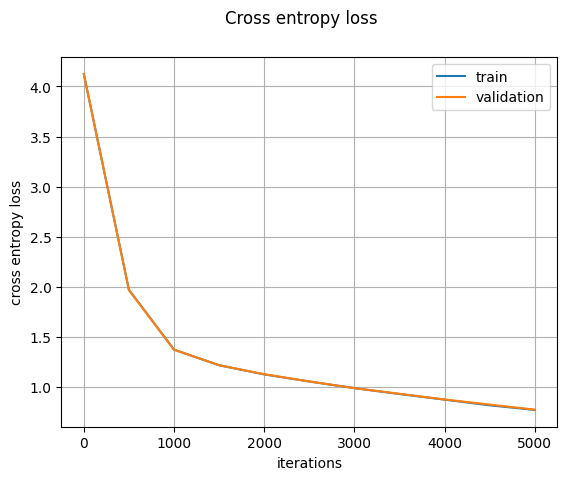

In [14]:
# reconstructed from logging as it was overwritten due to not paying attention
all_losses_train_large = [4.124,1.9689,1.3708,1.2148,1.1235,1.0525,0.9862,0.9275,0.8712,0.8146,0.7686]
all_losses_test_large = [4.1255,1.9659,1.3703,1.2156,1.1252,1.0531,0.9861,0.9299,0.8729,0.8218,0.7713]

plt.plot(iteration_vec,all_losses_train_large)
plt.xlabel("iterations")
plt.ylabel("cross entropy loss")
plt.grid()
plt.plot(iteration_vec,all_losses_test_large)
plt.legend(["train", "validation"])
plt.suptitle("Cross entropy loss")


plt.show()